Found 8204 images belonging to 18 classes.
Found 1751 images belonging to 18 classes.
Found 1782 images belonging to 18 classes.


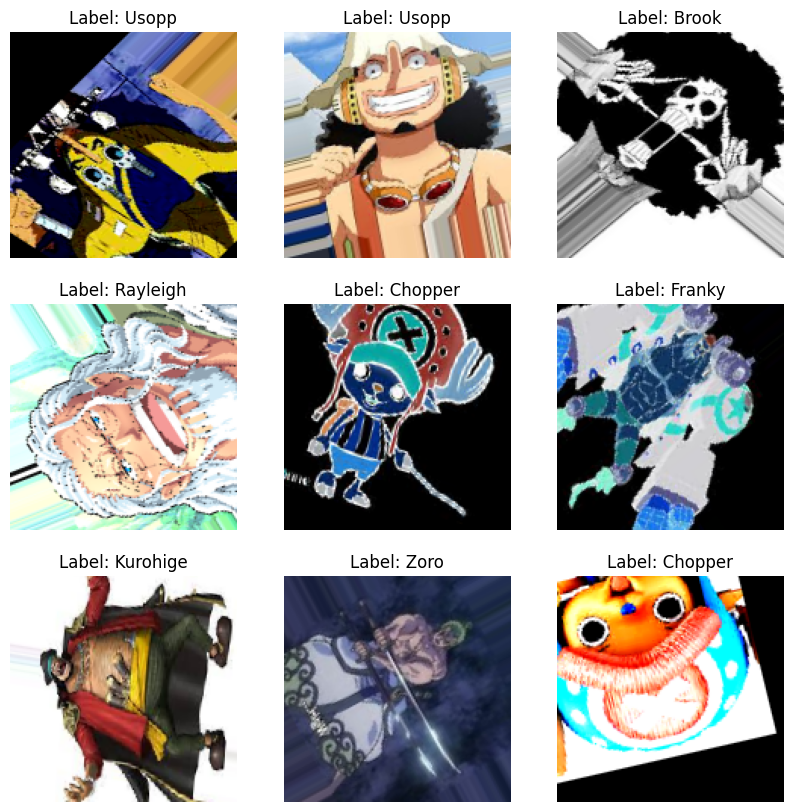

In [1]:
import os
import shutil
import numpy as np
import keras
import logging
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential

def create_directories(base_dir, categories):
    """
    Create directories for training, testing, and validation datasets.

    Parameters:
    - base_dir (str): The base directory where the train, test, and validation directories will be created.
    - categories (list): List of category names (sub-directory names) to create inside each of train, test, and validation directories.
    """
    for subset in ['train', 'test', 'validation']:
        for category in categories:
            dir_path = os.path.join(base_dir, subset, category)
            os.makedirs(dir_path, exist_ok=True)
            logging.info(f'Created directory: {dir_path}')

def copy_images(source_dir, images, dest_dir):
    """
    Copy images from source directory to destination directory.

    Parameters:
    - source_dir (str): The directory containing the source images.
    - images (list): List of image filenames to copy.
    - dest_dir (str): The destination directory where images will be copied.
    """
    for image in images:
        shutil.copy(os.path.join(source_dir, image), os.path.join(dest_dir, image))
        logging.info(f'Copied {image} to {dest_dir}')

def split_dataset(source_dir, base_dir, split_ratios=(0.7, 0.15, 0.15)):
    """
    Split the dataset into training, testing, and validation sets.

    Parameters:
    - source_dir (str): The source directory containing subdirectories of images for each category.
    - base_dir (str): The base directory where the split datasets will be stored.
    - split_ratios (tuple): A tuple containing the ratios for splitting the dataset into train, test, and validation sets.

    Raises:
    - ValueError: If the split ratios do not sum to 1.
    """
    if sum(split_ratios) != 1:
        raise ValueError("Split ratios must sum to 1. Provided ratios sum to {:.2f}".format(sum(split_ratios)))
    
    categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    create_directories(base_dir, categories)

    for category in categories:
        category_path = os.path.join(source_dir, category)
        images = os.listdir(category_path)
        np.random.shuffle(images)

        train_split = int(len(images) * split_ratios[0])
        test_split = int(len(images) * split_ratios[1])

        train_images = images[:train_split]
        test_images = images[train_split:train_split + test_split]
        validation_images = images[train_split + test_split:]

        copy_images(category_path, train_images, os.path.join(base_dir, 'train', category))
        copy_images(category_path, test_images, os.path.join(base_dir, 'test', category))
        copy_images(category_path, validation_images, os.path.join(base_dir, 'validation', category))
        
def preprocess_image(image_path):
    img = Image.open(image_path)
    if img.mode == 'P' and 'transparency' in img.info:
        img = img.convert('RGBA')
        img = img.convert('RGB')
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    return img

def setup_and_split_dataset(source_dir='Data', base_dir='Dataset_Split', split_ratios=(0.7, 0.15, 0.15)):
    """
    Set up logging, define directories, and split the dataset.

    Parameters:
    - source_dir (str): The source directory containing subdirectories of images for each category.
    - base_dir (str): The base directory where the split datasets will be stored.
    - split_ratios (tuple): A tuple containing the ratios for splitting the dataset into train, test, and validation sets.
    """
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    try:
        split_dataset(source_dir, base_dir, split_ratios)
    except ValueError as e:
        logging.error(e)
        
def load_dataset(base_dir, target_size=(150, 150), batch_size=32, augmentation=False):
    """
    Load the dataset into variables using ImageDataGenerator.

    Parameters:
    - base_dir (str): The base directory where the split datasets are stored.
    - target_size (tuple): The dimensions to which all images found will be resized.
    - batch_size (int): Size of the batches of data (default: 32).
    - augmentation (bool): Whether to apply data augmentation to the training dataset (default: False).

    Returns:
    - train_generator (DirectoryIterator): Iterator for training dataset.
    - test_generator (DirectoryIterator): Iterator for testing dataset.
    - validation_generator (DirectoryIterator): Iterator for validation dataset.
    """
    if augmentation:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(base_dir, 'validation'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

    return train_generator, test_generator, validation_generator

def display_images(images, labels, classes):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i]
        if image.shape[-1] == 3:
            image = np.clip(image * 255, 0, 255).astype("uint8")
        plt.imshow(image)
        class_name = classes[labels[i].argmax()]
        plt.title(f"Label: {class_name}")
        plt.axis("off")
    plt.show()

if __name__ == "__main__":
    # setup_and_split_dataset()
    
    classes = {
        0: 'Ace',
        1: 'Akainu',
        2: 'Brook',
        3: 'Chopper',
        4: 'Crocodile',
        5: 'Franky',
        6: 'Jinbei',
        7: 'Kurohige',
        8: 'Law',
        9: 'Luffy',
        10: 'Mihawk',
        11: 'Nami',
        12: 'Rayleigh',
        13: 'Robin',
        14: 'Sanji',
        15: 'Shanks',
        16: 'Usopp',
        17: 'Zoro',
    }
    
    base_dir = 'Dataset_Split'
    train_generator, test_generator, validation_generator = load_dataset(base_dir, augmentation=True)

    images, labels = next(train_generator)
    display_images(images, labels, classes)


In [2]:


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dense(18, activation='sigmoid')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,042,898 (72.64 MB)

 Trainable params: 19,042,898 (72.64 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  5/257 ━━━━━━━━━━━━━━━━━━━━ 4:58 1s/step - acc: 0.0362 - loss: 3.3869

c:\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


257/257 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - acc: 0.0931 - loss: 2.8659 - val_acc: 0.1684 - val_loss: 2.6591
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - acc: 0.2130 - loss: 2.5210 - val_acc: 0.2688 - val_loss: 2.4239
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - acc: 0.3121 - loss: 2.2430 - val_acc: 0.3614 - val_loss: 2.1478
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - acc: 0.3507 - loss: 2.1050 - val_acc: 0.3844 - val_loss: 1.9621
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - acc: 0.4258 - loss: 1.9020 - val_acc: 0.4343 - val_loss: 1.8425
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - acc: 0.4442 - loss: 1.7949 - val_acc: 0.4618 - val_loss: 1.7695
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - acc: 0.4969 - loss: 1.6593 - val_acc: 0.5079 - val_loss: 1.7035
Epoch 8/20
203/257 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - acc: 0.5180 - loss: 1.5675

In [ ]:
test_x, test_y = validation_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])